'vine snake: 96.7%'
Gradients size is torch.Size([1, 512, 7, 7])
GAPed gradients size is torch.Size([512])
tensor([-0.0009,  0.0002,  0.0019,  0.0003, -0.0019,  0.0013,  0.0014, -0.0010,
         0.0003, -0.0011])
FC wts size is torch.Size([1000, 512])
In our python check scripts we only print first 10:
tensor([-0.0185, -0.0705, -0.0518, -0.0098,  0.0147, -0.0132, -0.0382,  0.2506,
        -0.0257, -0.0542], grad_fn=<SliceBackward0>)
Actual output class first 10 weights are
tensor([-0.0436,  0.0082,  0.0915,  0.0165, -0.0929,  0.0647,  0.0667, -0.0476,
         0.0126, -0.0549], grad_fn=<SliceBackward0>)
Activations size is torch.Size([1, 512, 7, 7])
Post mult activations size is torch.Size([1, 512, 7, 7])
tensor([[-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00],
        [-1.1864e-04, -1.6674e-04, -0.0000e+00, -0.0000e+00, -0.

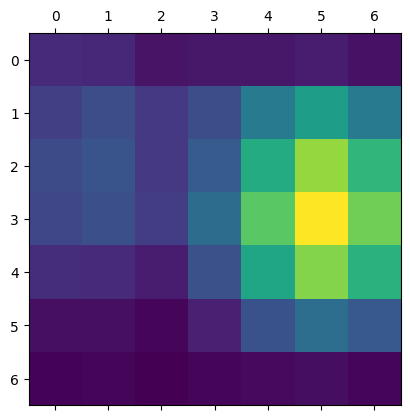

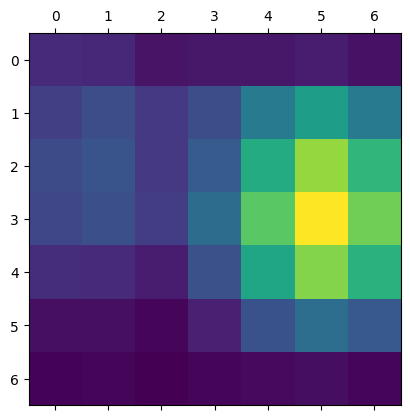

In [21]:
from traitlets.config.application import T
import torch
import torch.nn as nn
from torchvision.models import resnet152, ResNet152_Weights, resnet18, ResNet18_Weights
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils import data
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.io import read_image
from pprint import pprint
from google.colab.patches import cv2_imshow
from IPython.display import Image
import cv2

is18 = not False
is152 = not is18

debug = True
do_base_CAM = True

if (is18):
    weights = ResNet18_Weights.IMAGENET1K_V1
else:
    weights = ResNet152_Weights.IMAGENET1K_V1

# file_path = "/content/sample_data/n02028035_redshank.jpeg"
# file_path = "/content/sample_data/n04146614_school_bus.jpeg"
# file_path = "/content/sample_data/n04141975_scale.jpeg"
# file_path = "/content/sample_data/cat_heatmap.png"
file_path = "/content/sample_data/n01739381_vine_snake.jpeg"

class MyResNet(nn.Module):
    def __init__(self):
        super(MyResNet, self).__init__()
        
        if (is18):
            self.resnet = resnet18(pretrained=True)
        else:
            self.resnet = resnet152(weights=weights)
        
        self.features = nn.Sequential(self.resnet.conv1,
                                      self.resnet.bn1,
                                      self.resnet.relu,
                                      self.resnet.maxpool,
                                      self.resnet.layer1, 
                                      self.resnet.layer2, 
                                      self.resnet.layer3, 
                                      self.resnet.layer4)
        
        self.avgpool = self.resnet.avgpool
        self.classifier = self.resnet.fc

        self.gradient_var = None
    
    def activations_hook(self, grad):
        self.gradient_var = grad
    
    def get_gradient(self):
        return self.gradient_var
    
    def get_activations(self, x):
        return self.features(x)
    
    def forward(self, x):
        x = self.features(x)
        
        h = x.register_hook(self.activations_hook)
        
        x = self.avgpool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        
        return x

transform = weights.transforms()

i = read_image(file_path)
img = transform(i).unsqueeze(0)

myresnet = MyResNet()
_ = myresnet.eval()

fwd_res = myresnet(img)

# Softmax is to normalize the score in %
output = fwd_res.squeeze(0).softmax(0)
output_class_idx = output.argmax().item()
output_score = output[output_class_idx].item()
output_class = weights.meta["categories"][output_class_idx]
pprint(f"{output_class}: {100 * output_score:.1f}%")

# dy/dA from the paper
fwd_res[:, output_class_idx].backward()
gradients = myresnet.get_gradient()
if debug:
    print("Gradients size is " + str(gradients.size()))

gaped_gradients = torch.mean(gradients, dim=[0, 2, 3])
if debug:
    print("GAPed gradients size is " + str(gaped_gradients.size()))
    print(gaped_gradients[:10])

# Checking if GAP matches FC layer weights
fc_w = myresnet.resnet.fc.weight
if debug:
    print("FC wts size is " + str(fc_w.size()))
    print("In our python check scripts we only print first 10:")
    print(fc_w[0][:10])
    print("Actual output class first 10 weights are")
    print(fc_w[output_class_idx][:10])

l41_c2_out = myresnet.get_activations(img).detach()
if debug:
    print("Activations size is " + str(l41_c2_out.size()))

for i in range(512):
    l41_c2_out[:, i, :, :] *= gaped_gradients[i]

if debug:
    print("Post mult activations size is " + str(l41_c2_out.size()))
    print(l41_c2_out[0][0])
    
heatmap = torch.mean(l41_c2_out, dim=1).squeeze()
if debug:
    print("Heatmap size is " + str(heatmap.size()))
    print(heatmap)

heatmap = np.maximum(heatmap, 0)    # ReLU
heatmap /= torch.max(heatmap)       # Normalize

plt.matshow(heatmap.squeeze())

heatmap = heatmap.numpy()
if debug:
    print("First few values of heatmap are")
    print(heatmap[:10])
read_img = cv2.imread(file_path)
heatmap = cv2.resize(heatmap, (read_img.shape[1], read_img.shape[0])) # Bilinear
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + read_img
cv2.imwrite('./superimposed.jpg', superimposed_img)
Image(filename='superimposed.jpg') 

if do_base_CAM:
    l41_c2_out_base = myresnet.get_activations(img).detach()
    wts_base = fc_w[output_class_idx].squeeze()

    for i in range(512):
        l41_c2_out_base[:, i, :, :] *= wts_base[i]

    base_heatmap = torch.mean(l41_c2_out, dim=1).squeeze()
    print("First few un normalized values of base CAM heatmap are")
    print(base_heatmap[:10])

    base_heatmap = np.maximum(base_heatmap, 0)    # ReLU
    base_heatmap /= torch.max(base_heatmap)       # Normalize

    print("First few values of base CAM heatmap are")
    print(base_heatmap[:10])

    plt.matshow(base_heatmap.squeeze())


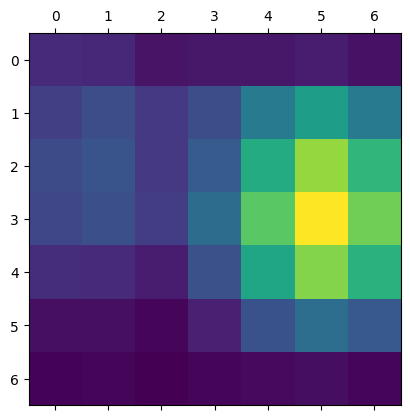

In [37]:
import numpy as np
import os
import torch
import cv2
import matplotlib.pyplot as plt

cpp_out_path = '/content/sample_data'

cam_out = np.fromfile(os.path.join(cpp_out_path, 'cam_output.bin'), dtype=np.float32)
# weights = np.fromfile(os.path.join(cpp_out_path, 'fc_weight.bin'), dtype=np.float32)
# output = np.fromfile(os.path.join(cpp_out_path, 'output.bin'), dtype=np.float32)
# inp_act = np.fromfile(os.path.join(cpp_out_path, 'l41_c2_out.bin'), dtype=np.float32)

heatmap = torch.from_numpy(cam_out.reshape(7,7))
heatmap /= torch.max(heatmap)

plt.matshow(heatmap.squeeze())

# make the heatmap to be a numpy array
# heatmap = heatmap.numpy()

# interpolate the heatmap
# img = cv2.imread(file_path)
# heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
# heatmap = np.uint8(255 * heatmap)
# heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
# superimposed_img = heatmap * 0.4 + img
# cv2.imwrite('./map.jpg', superimposed_img)